In [82]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import wandb
import numpy as np
import torch
import pandas as pd

In [83]:
api = wandb.Api()

In [84]:
def download_predictions(artifact_names: list[str]) -> tuple[tuple[np.array, np.array]]:
    ret = []

    for artifact_name in artifact_names:
        artifact = api.artifact(artifact_name)
        path = artifact.download()
        labels = np.load(path + '/labels.npy')
        predictions = np.load(path + '/predictions.npy')
        # Apply softmax to prediction logits using torch
        predictions_t = torch.tensor(predictions)
        probs = torch.nn.functional.softmax(predictions_t, dim=-1)
        predictions = torch.argmax(probs, dim=1, keepdim=True).flatten().numpy()
        ret.append((predictions, labels))
    
    return tuple(ret)

In [85]:
def get_misclassified_samples(predictions: np.array, data_path: str):
    # Load the dataframe from the provided data path
    df = pd.read_csv(data_path)
    
    # Convert the "class_label" column to integers (Yes -> 1, No -> 0)
    df['class_label'] = df['class_label'].map({'Yes': 1, 'No': 0})
    
    # Retrieve rows where the "class_label" column does not match the predictions
    misclassified_samples = df[df['class_label'] != predictions]
    
    return misclassified_samples

In [95]:
from collections import Counter

def get_misclassification_overlap(misclassified: list[pd.DataFrame], min_num_misclassified: int):
    # Combine all misclassified dataframes into a single dataframe with an identifier for each dataframe
    combined = pd.concat(misclassified, ignore_index=True)
    
    # Count occurrences of each Sentence_id across all dataframes
    counts = combined['Sentence_id'].value_counts()
    
    # Filter Sentence_ids that appear in at least min_num_misclassified dataframes
    frequent_ids = counts[counts >= min_num_misclassified].index
    
    # Retrieve rows with those Sentence_ids
    result = combined[combined['Sentence_id'].isin(frequent_ids)]

    # Remove duplicate rows based on 'Sentence_id', keeping the first occurrence
    result = result.drop_duplicates(subset='Sentence_id')
    
    return result

In [87]:
artifact_base_name = "redstag/thesis/"
ct24_predictions = [
    "test_predictions:v1",
    "test_predictions:v2",
    "test_predictions:v3"
]
ct24_double_predictions = [
    "test_predictions:v4",
    "test_predictions:v5",
    "test_predictions:v6"
]
synthetic_only_predictions = [
    "test_predictions:v7"
]

In [88]:
predictions_ct24 = download_predictions([artifact_base_name + pred for pred in ct24_predictions])
conf_mats_ct24 = [confusion_matrix(labels, preds) for preds, labels in predictions_ct24]
predictions_ct24_double = download_predictions([artifact_base_name + pred for pred in ct24_double_predictions])
conf_mats_ct24_double = [confusion_matrix(labels, preds) for preds, labels in predictions_ct24_double]
predictions_synth = download_predictions([artifact_base_name + pred for pred in synthetic_only_predictions])
conf_mats_synth = [confusion_matrix(labels, preds) for preds, labels in predictions_synth]

wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  


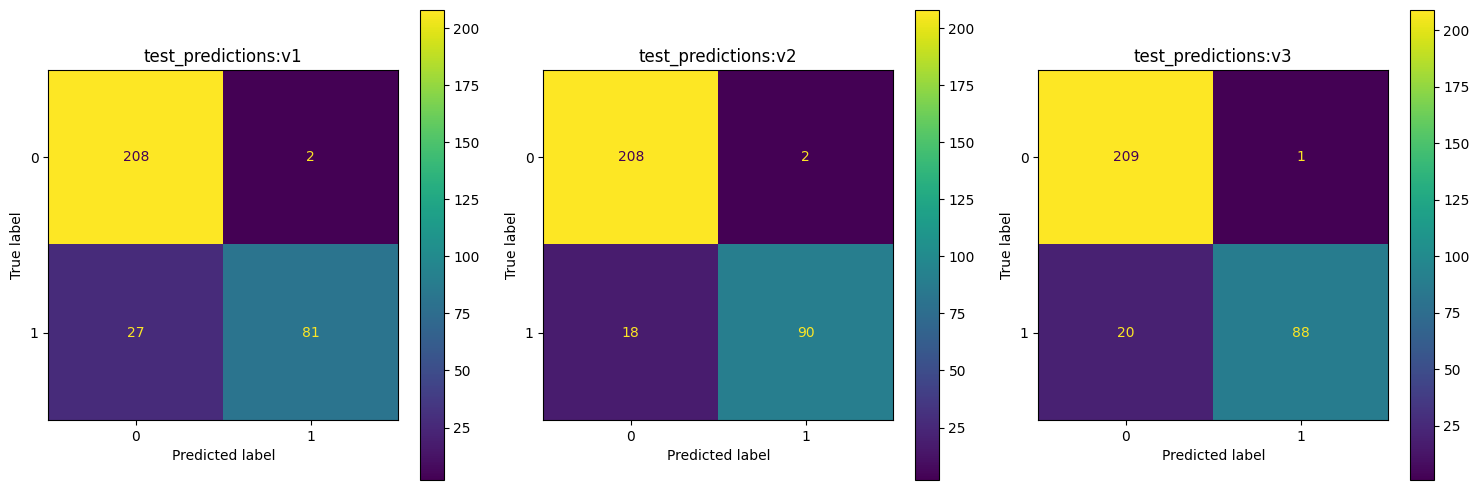

In [89]:
fig, axes = plt.subplots(1, len(conf_mats_ct24), figsize=(15, 5))

for ax, cm, artifact_name in zip(axes, conf_mats_ct24, ct24_predictions):
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(ax=ax)
    ax.title.set_text(artifact_name)

plt.tight_layout()
plt.show()

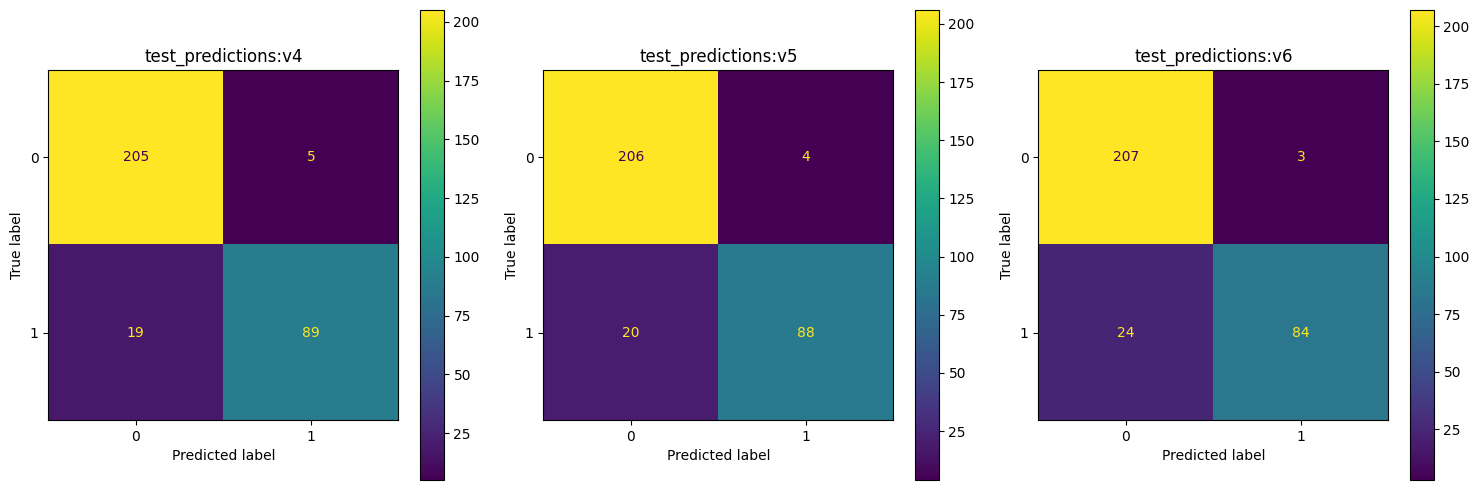

In [90]:
fig, axes = plt.subplots(1, len(conf_mats_ct24_double), figsize=(15, 5))

for ax, cm, artifact_name in zip(axes, conf_mats_ct24_double, ct24_double_predictions):
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(ax=ax)
    ax.title.set_text(artifact_name)

plt.tight_layout()
plt.show()

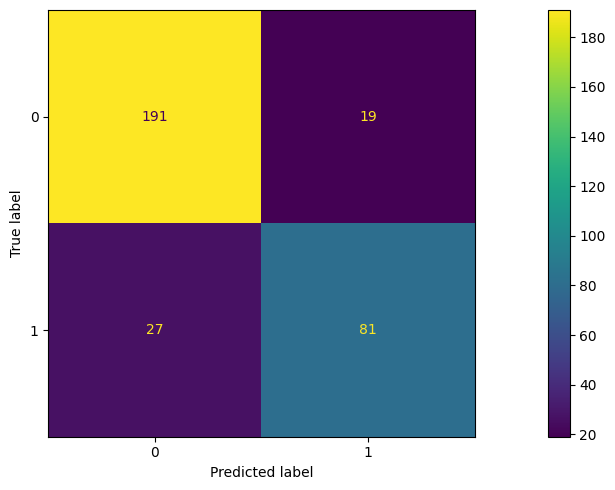

In [91]:
fig, axes = plt.subplots(1, 1, figsize=(15, 5))

disp = ConfusionMatrixDisplay(conf_mats_synth[0])
disp.plot(ax=axes)
ax.title.set_text(synthetic_only_predictions[0])

plt.tight_layout()
plt.show()

In [92]:
dev_test_path = "../data/CT24_checkworthy_english/csv/CT24_checkworthy_english_dev-test.csv"
misclassified_ct24 = [get_misclassified_samples(preds, dev_test_path) for preds, _ in predictions_ct24]

In [99]:
mo = get_misclassification_overlap(misclassified_ct24, min_num_misclassified=3)
mo

,Sentence_id,Text,class_label
2,38075,He's been totally irresponsible the way in whi...,1
3,38156,Because it costs a lot of money to open them s...,1
4,38294,"And plenty of companies that are already here,...",1
5,38310,Manufacturing went in a hole-,1
6,38513,The general who was with him said All he ever ...,1
7,38562,"There's systemic injustice in this country, in...",1
8,38666,The places we had trouble were Democratic-run ...,1
9,39105,"Yeah, you did say that.",1
10,39120,So why didn't he do it for 47 years?,1
11,39132,The Green New Deal is not my plan...,1
